In [1]:
# Inspired by https://github.com/dennybritz/reinforcement-learning
import gym
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from gym import wrappers
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor

In [2]:
def plot_running_avg(totalrewards):
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

In [3]:
class FeatureTransformer:
    def __init__(self, env, n_components=500):
        observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        scaler = StandardScaler()
        scaler.fit(observation_examples)

        # Used to converte a state to a featurizes represenation.
        # We use RBF kernels with different variances to cover different parts of the space
        featurizer = FeatureUnion([
                ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
                ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
                ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
                ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
                ])
        example_features = featurizer.fit_transform(scaler.transform(observation_examples))

        self.dimensions = example_features.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer

    def transform(self, observations):
        # print "observations:", observations
        scaled = self.scaler.transform(observations)
        # assert(len(scaled.shape) == 2)
        return self.featurizer.transform(scaled)


# Holds one SGDRegressor for each action
class Model:
    def __init__(self, env, feature_transformer, learning_rate):
        self.env = env
        self.models = []
        self.feature_transformer = feature_transformer
        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate=learning_rate)
            model.partial_fit(feature_transformer.transform( [env.reset()] ), [0])
            self.models.append(model)

    def predict(self, s):
        X = self.feature_transformer.transform([s])
        result = np.stack([m.predict(X) for m in self.models]).T
        assert(len(result.shape) == 2)
        return result

    def update(self, s, a, G):
        X = self.feature_transformer.transform([s])
        assert(len(X.shape) == 2)
        self.models[a].partial_fit(X, [G])

    def sample_action(self, s, eps):
        # eps = 0
        # Technically, we don't need to do epsilon-greedy
        # because SGDRegressor predicts 0 for all states
        # until they are updated. This works as the
        # "Optimistic Initial Values" method, since all
        # the rewards for Mountain Car are -1.
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(s))

In [4]:
def plot_cost_to_go(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    # both X and Y will be of shape (num_tiles, num_tiles)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))
    # Z will also be of shape (num_tiles, num_tiles)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z,
        rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Cost-To-Go == -V(s)')
    ax.set_title("Cost-To-Go Function")
    fig.colorbar(surf)
    plt.show()

In [5]:
def play_one(model, env, eps, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    while not done and iters < 10000:
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)

        # update the model
        next = model.predict(observation)
        # assert(next.shape == (1, env.action_space.n))
        G = reward + gamma*np.max(next[0])
        model.update(prev_observation, action, G)

        totalreward += reward
        iters += 1

    return totalreward

In [6]:
def main(show_plots=True):
    env = gym.make('MountainCar-v0')
    ft = FeatureTransformer(env)
    model = Model(env, ft, "constant")
    gamma = 0.99

    if 'monitor' in sys.argv:
        filename = os.path.basename(__file__).split('.')[0]
        monitor_dir = './' + filename + '_' + str(datetime.now())
        env = wrappers.Monitor(env, monitor_dir)


    N = 700
    totalrewards = np.empty(N)
    for n in range(N):
        # eps = 1.0/(0.1*n+1)
        eps = 0.1*(0.97**n)
        if n == 199:
            print("eps:", eps)
        # eps = 1.0/np.sqrt(n+1)
        totalreward = play_one(model, env, eps, gamma)
        totalrewards[n] = totalreward
        if (n + 1) % 100 == 0:
            print("episode:", n, "total reward:", totalreward)
    print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
    print("total steps:", -totalrewards.sum())

    if show_plots:
        plt.plot(totalrewards)
        plt.title("Rewards")
        plt.show()

        plot_running_avg(totalrewards)

    # plot the optimal state-value function
        plot_cost_to_go(env, model)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode: 99 total reward: -148.0
eps: 0.00023311762989647067
episode: 199 total reward: -150.0
episode: 299 total reward: -104.0
episode: 399 total reward: -136.0
episode: 499 total reward: -152.0
episode: 599 total reward: -141.0
episode: 699 total reward: -143.0
avg reward for last 100 episodes: -133.68
total steps: 93664.0


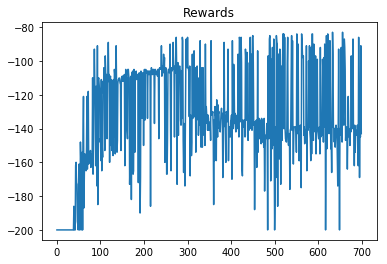

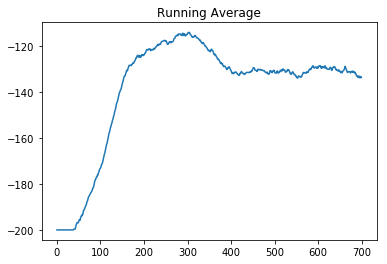

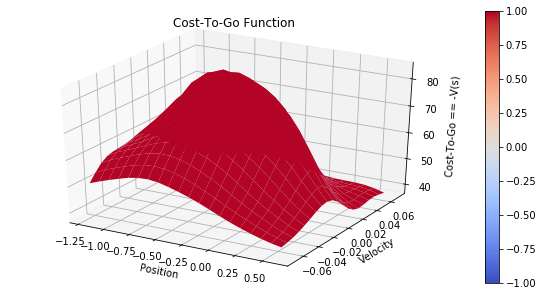

In [7]:
main()

# Discussion
We use the similar method of RBF kernels in this example with a few modifications.

As we discussed in the previous section that we need to run the partial fit function on a dummy value. Here we set target as 0 and call the fit function on the start state. An implication of this is that this would make all the predictions 0 for a while, but this fact can infact be useful for us as in Mountain Car all the rewards are -1 and having a target of 0 is infact benefitial. This strategy can be thought of as being Optimistic of the inital values and this obviates the need of epsilon greedy policy for this environment.